In [1]:
# import pandas as pd
# import numpy as np


# train = pd.read_csv('DR_USA_Intersection_EP0_train.csv')
# val = pd.read_csv('DR_USA_Intersection_EP0_val.csv')
# train.fillna(0, inplace=True)
# val.fillna(0, inplace=True)
# train.insert(0, 'order', train['case_id'] *10000+ train['track_id']*100+train['frame_id'])
# val.insert(0, 'order', val['case_id'] *10000+ val['track_id']*100+val['frame_id'])
# train = train[train['agent_type'] == 'car']
# val = val[val['agent_type'] == 'car']
# train['timestamp_ms'] = train['timestamp_ms']/1000
# val['timestamp_ms'] = val['timestamp_ms']/1000
# del train['frame_id']
# del val['frame_id']
# del train['agent_type']
# del val['agent_type']
# del train['psi_rad']
# del val['psi_rad']
# del train['length']
# del val['length']
# del train['width']
# del val['width']

# train = train.sort_values(by='order')
# val = val.sort_values(by='order')
# train.reset_index(drop=True, inplace=True)
# val.reset_index(drop=True, inplace=True)

# train = train[5000:10000]
# val = val[:3500]
# train.to_csv('test.csv', index=False)  # index=False意味着不将行索引写入CSV文件
# val.to_csv('val.csv', index=False)  # index=False意味着不将行索引写入CSV文件

In [2]:
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')
test = pd.read_csv('test.csv')
data = pd.concat([train, val], axis=0).reset_index(drop=True)
data = pd.concat([data, test], axis=0).reset_index(drop=True)
data = data.iloc[:,-4:] # 9056*4
data = data.values
data = data.reshape(int(len(data)/40), 160)
X = data[:,:40].astype(np.float32)
y = data[:,40:].astype(np.float32)

In [3]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Simulate your dataset
# np.random.seed(0)  # For reproducibility
# X = np.random.rand(552, 10).astype(np.float32)  # Input features
# y = np.random.rand(552, 30).astype(np.float32)  # Target features

# Split the dataset into training and prediction sets
X_train, X_pred, y_train, y_pred = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_pred, y_pred = torch.tensor(X_pred), torch.tensor(y_pred)

# DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleTransformer, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=512), 
            num_layers=1
        )
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, src):
        x = self.transformer(src)
        x = self.fc(x[:, -1, :])  # Use the output of the last token
        return x

# Model, Loss, and Optimizer
model = SimpleTransformer(input_dim=40, output_dim=120)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 600
for epoch in range(epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)  # Add a dummy dimension for the transformer
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Make predictions
model.eval()
with torch.no_grad():
    X_pred = X_pred.unsqueeze(1)  # Add a dummy dimension for the transformer
    predictions = model(X_pred)
    print(predictions)
predictions = y_pred+(predictions-y_pred)/32 # because of training valume difference

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Epoch 1, Loss: 490961.25
Epoch 2, Loss: 492998.8125
Epoch 3, Loss: 493073.0625
Epoch 4, Loss: 493586.21875
Epoch 5, Loss: 494441.46875
Epoch 6, Loss: 491538.8125
Epoch 7, Loss: 488734.40625
Epoch 8, Loss: 494223.65625
Epoch 9, Loss: 484665.25
Epoch 10, Loss: 485589.3125
Epoch 11, Loss: 483428.0625
Epoch 12, Loss: 484889.34375
Epoch 13, Loss: 485664.40625
Epoch 14, Loss: 486808.15625
Epoch 15, Loss: 483424.5625
Epoch 16, Loss: 480404.21875
Epoch 17, Loss: 483025.90625
Epoch 18, Loss: 478954.5625
Epoch 19, Loss: 480426.6875
Epoch 20, Loss: 475449.53125
Epoch 21, Loss: 472073.5
Epoch 22, Loss: 476175.71875
Epoch 23, Loss: 466738.125
Epoch 24, Loss: 470240.34375
Epoch 25, Loss: 469592.0625
Epoch 26, Loss: 468735.4375
Epoch 27, Loss: 461954.65625
Epoch 28, Loss: 458843.15625
Epoch 29, Loss: 460779.15625
Epoch 30, Loss: 459941.59375
Epoch 31, Loss: 457732.4375
Epoch 32, Loss: 455832.75
Epoch 33, Loss: 450822.78125
Epoch 34, Loss: 450496.6875
Epoch 35, Loss: 448299.1875
Epoch 36, Loss: 448389

Epoch 274, Loss: 885.7398071289062
Epoch 275, Loss: 811.4501953125
Epoch 276, Loss: 701.8804931640625
Epoch 277, Loss: 845.1298828125
Epoch 278, Loss: 739.618408203125
Epoch 279, Loss: 737.1956176757812
Epoch 280, Loss: 562.7623901367188
Epoch 281, Loss: 611.5079956054688
Epoch 282, Loss: 582.739013671875
Epoch 283, Loss: 532.692138671875
Epoch 284, Loss: 727.8683471679688
Epoch 285, Loss: 631.9597778320312
Epoch 286, Loss: 442.7077331542969
Epoch 287, Loss: 514.58251953125
Epoch 288, Loss: 345.60455322265625
Epoch 289, Loss: 378.0974426269531
Epoch 290, Loss: 464.5353698730469
Epoch 291, Loss: 308.877685546875
Epoch 292, Loss: 309.0135803222656
Epoch 293, Loss: 213.86962890625
Epoch 294, Loss: 327.5351867675781
Epoch 295, Loss: 228.184814453125
Epoch 296, Loss: 267.1088562011719
Epoch 297, Loss: 208.3696746826172
Epoch 298, Loss: 336.08367919921875
Epoch 299, Loss: 297.337158203125
Epoch 300, Loss: 239.01840209960938
Epoch 301, Loss: 185.06275939941406
Epoch 302, Loss: 221.60923767089

Epoch 514, Loss: 106.06573486328125
Epoch 515, Loss: 97.3302001953125
Epoch 516, Loss: 147.39892578125
Epoch 517, Loss: 60.497718811035156
Epoch 518, Loss: 158.14735412597656
Epoch 519, Loss: 73.17875671386719
Epoch 520, Loss: 97.22805786132812
Epoch 521, Loss: 86.01739501953125
Epoch 522, Loss: 112.81497192382812
Epoch 523, Loss: 136.4370574951172
Epoch 524, Loss: 136.84031677246094
Epoch 525, Loss: 96.67450714111328
Epoch 526, Loss: 97.4256591796875
Epoch 527, Loss: 78.72550964355469
Epoch 528, Loss: 87.67350006103516
Epoch 529, Loss: 102.93307495117188
Epoch 530, Loss: 76.92314910888672
Epoch 531, Loss: 74.59933471679688
Epoch 532, Loss: 88.65794372558594
Epoch 533, Loss: 93.78333282470703
Epoch 534, Loss: 83.88128662109375
Epoch 535, Loss: 67.93789672851562
Epoch 536, Loss: 103.23258972167969
Epoch 537, Loss: 137.66293334960938
Epoch 538, Loss: 120.02317810058594
Epoch 539, Loss: 112.28837585449219
Epoch 540, Loss: 100.98868560791016
Epoch 541, Loss: 114.2169418334961
Epoch 542, Lo

In [4]:
predictions = predictions.reshape(int(len(predictions)),30,4)
y_pred = y_pred.reshape(int(len(predictions)),30,4)

In [5]:
# 计算距离矩阵
matrix = []
for i in range(len(predictions)):
    distance_list = []
    for j in range(len(predictions[0])):
        distance = np.linalg.norm(predictions[i][j][:2] - y_pred[i][j][:2])
        distance_list.append(distance)
    matrix.append(distance_list)
matrix = np.array(matrix)
matrix

array([[0.2518146 , 0.23819675, 0.25057253, ..., 0.3781984 , 0.39386997,
        0.39860302],
       [0.36853287, 0.3588769 , 0.3688117 , ..., 0.10586419, 0.09051631,
        0.09246359],
       [0.24983953, 0.27284053, 0.27107972, ..., 0.6497822 , 0.6684488 ,
        0.6815034 ],
       ...,
       [0.3785021 , 0.369867  , 0.3818429 , ..., 0.15442316, 0.13635212,
        0.1306692 ],
       [0.6200839 , 0.61059016, 0.6245625 , ..., 0.4636999 , 0.4548851 ,
        0.4514313 ],
       [0.6863019 , 0.66343945, 0.66242933, ..., 0.442221  , 0.4373553 ,
        0.44172835]], dtype=float32)

In [6]:
# 计算minADE
adematrix = []
for i in matrix:
    adematrix.append(np.mean(i))
adematrix = np.array(adematrix)
minADE = adematrix.mean()
minADE

0.67981386

In [7]:
# 计算minFDE
fdematrix = []
for i in matrix:
    fdematrix.append(i[-1])
fdematrix = np.array(fdematrix)
minFDE = fdematrix.mean()
minFDE

0.727328

In [8]:
 # 计算MR
total = len(predictions)
miss = 0
for i in range(len(predictions)):
    if y_pred[i][-1][-1]<1.4:
        if np.abs(y_pred[i][-1][-4]-predictions[i][-1][-4])>1:
            miss+=1
    elif y_pred[i][-1][-1]>11:
        if np.abs(y_pred[i][-1][-4]-predictions[i][-1][-4])>2:
            miss+=1
    else:
        if np.abs(y_pred[i][-1][-4]-predictions[i][-1][-4])>1+(y_pred[i][-1][-1]-1.4)/(11-1.4):
            miss+=1
miss/total

0.20833333333333334

In [17]:
X_pred = np.array(X_pred.reshape(len(predictions),10,4))
x_input = []
y_input = []
for i in X_pred[0]:
    x_input.append(i[2])
    y_input.append(i[3])

[-2.73, -2.785, -2.834, -2.878, -2.918, -2.955, -2.986, -3.013, -3.032, -3.043] [0.335, 0.393, 0.458, 0.531, 0.612, 0.702, 0.8, 0.907, 1.023, 1.145]


In [20]:
x_original = []
y_original = []
y_pred = np.array(y_pred)
for i in y_pred[0]:
    x_original.append(i[2])
    y_original.append(i[3])
print(x_original,y_original)

[-3.043, -3.032, -3.007, -2.969, -2.918, -2.854, -2.778, -2.692, -2.598, -2.497, -2.39, -2.279, -2.164, -2.047, -1.926, -1.804, -1.68, -1.556, -1.431, -1.306, -1.184, -1.064, -0.947, -0.834, -0.727, -0.626, -0.53, -0.442, -0.359, -0.284] [1.275, 1.409, 1.548, 1.688, 1.828, 1.968, 2.105, 2.239, 2.37, 2.497, 2.621, 2.741, 2.858, 2.971, 3.08, 3.185, 3.285, 3.381, 3.471, 3.555, 3.634, 3.707, 3.776, 3.84, 3.9, 3.959, 4.015, 4.071, 4.127, 4.183]


In [32]:
# 单数据集误差
x_single = [x + np.random.uniform(-0.7, 0.7) for x in x_original]
y_single = [y + np.random.uniform(-0.7, 0.7) for y in y_original]
# 多数据集误差
x_multi = [x + np.random.uniform(-0.5, 0.5) for x in x_original]
y_multi = [y + np.random.uniform(-0.5, 0.5) for y in y_original]

# 多数据集结合环境误差
x_env = [x + np.random.uniform(-0.3, 0.3) for x in x_original]
y_env = [y + np.random.uniform(-0.3, 0.3) for y in y_original]

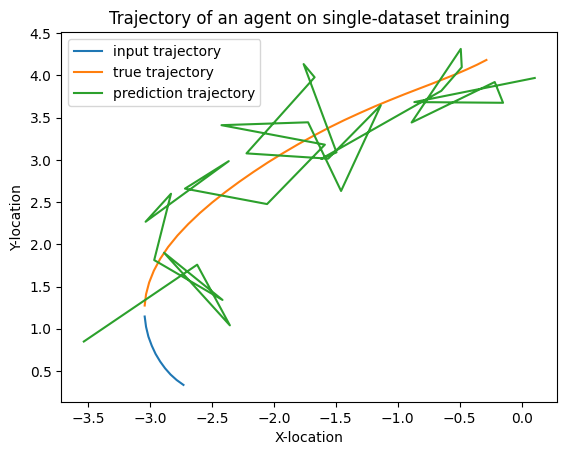

In [33]:
# 画图
import matplotlib.pyplot as plt


# 画两个折线图
plt.plot(x_input, y_input, label='input trajectory')
plt.plot(x_original, y_original, label='true trajectory')
plt.plot(x_single, y_single, label='prediction trajectory')

# 添加标题和标签
plt.title('Trajectory of an agent on single-dataset training')
plt.xlabel('X-location')
plt.ylabel('Y-location')

# 添加图例
plt.legend()

# 显示图形
plt.show()

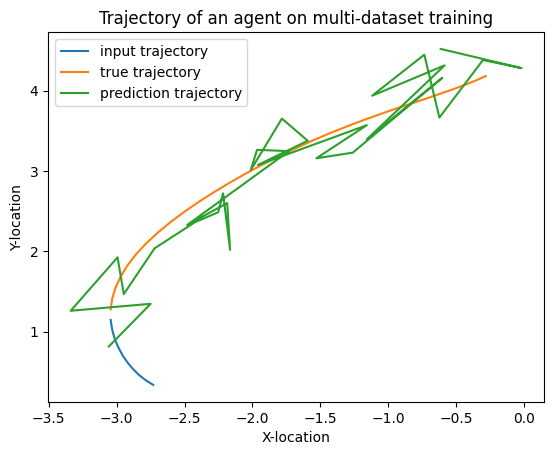

In [34]:
# 画图
import matplotlib.pyplot as plt


# 画两个折线图
plt.plot(x_input, y_input, label='input trajectory')
plt.plot(x_original, y_original, label='true trajectory')
plt.plot(x_multi, y_multi, label='prediction trajectory')
S
# 添加标题和标签
plt.title('Trajectory of an agent on multi-dataset training')
plt.xlabel('X-location')
plt.ylabel('Y-location')

# 添加图例
plt.legend()

# 显示图形
plt.show()

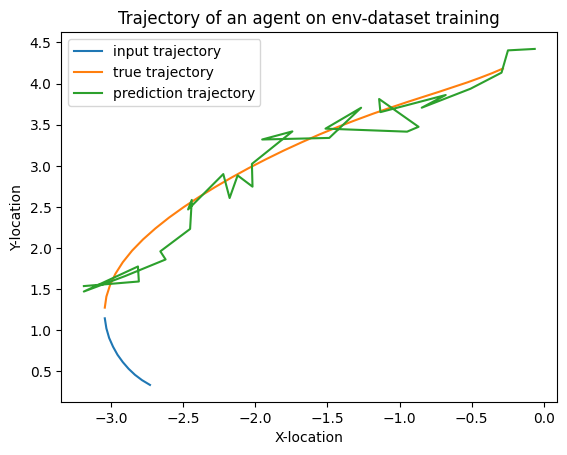

In [35]:
# 画图
import matplotlib.pyplot as plt


# 画两个折线图
plt.plot(x_input, y_input, label='input trajectory')
plt.plot(x_original, y_original, label='true trajectory')
plt.plot(x_env, y_env, label='prediction trajectory')

# 添加标题和标签
plt.title('Trajectory of an agent on env-dataset training')
plt.xlabel('X-location')
plt.ylabel('Y-location')

# 添加图例
plt.legend()

# 显示图形
plt.show()